Импорт библиотек

In [ ]:
# импорт библиотек

import torch_geometric
from torch_geometric.data import Data, DataLoader
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

import networkx as nx
import seaborn as sns

import os

Загрузка датасета

In [54]:
df_classes = pd.read_csv('./elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_edges = pd.read_csv('./elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_features = pd.read_csv('./elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)

df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)

df_merge = df_merge.drop(['txId'], axis=1)

df_merge.sample(n=5)

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
81611,248919252,18,-0.158121,-0.158783,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.148439,...,-0.178401,-0.979074,-0.978556,-0.098889,-0.08749,-0.084674,-0.140597,1.519700,1.521399,2
2436,232344790,1,-0.155907,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.146175,...,-0.235168,1.461330,1.461369,-0.098889,-0.08749,-0.084674,-0.140597,-1.760926,-1.760984,0
38577,96566026,7,-0.171837,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163602,...,-0.582077,-0.979074,-0.978556,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792,0
119665,166082553,29,-0.109908,-0.161609,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.099110,...,-0.582077,-0.979074,-0.978556,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792,2
65492,339983838,13,-0.172779,-0.197610,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163437,...,0.647874,1.461330,1.461369,-0.098889,-0.08749,-0.084674,-0.140597,-1.760926,-1.760984,2


Заменяем ID транзакций на номера, создаем набор ребер и весов

In [39]:
nodes = df_merge[0].values
map_id = {j: i for i, j in enumerate(nodes)}

edges = df_edges.copy()

edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)

edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

weights = torch.tensor([1] * edge_index.shape[1], dtype=torch.float32)

In [40]:
classified_idx = df_merge['class'].loc[df_merge['class'] != 2].index
unclassified_idx = df_merge['class'].loc[df_merge['class'] == 2].index

df_merge['class'] = df_merge['class'].replace(2, 0)

labels = torch.tensor(df_merge['class'].values, dtype=torch.float32)

node_features = torch.tensor(np.array(df_merge.drop([0, 'class', 1], axis=1).values), dtype=torch.float32)

Задаем соответствующий графовый датасет

In [41]:
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_weights = weights,
                        y = labels)
elliptic_dataset

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], edge_weights=[234355])

In [42]:
elliptic_dataset.x[classified_idx].shape

torch.Size([46564, 165])

In [43]:
print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


Гиперпараметры

In [44]:
seed = 0
learning_rate = 0.005
weight_decay = 1e-5
input_dim = 165
output_dim = 1
hidden_size = 100
num_epochs = 400
checkpoints_dir = './models/elliptic_tgnn'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

Разбивка на тренировочный и валидационный датасет

In [45]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = train_test_split(node_features[classified_idx],
                                                    y_train,
                                                    classified_idx,
                                                    test_size=0.15,
                                                    random_state=np.random.seed(seed),
                                                    stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])


Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


Модель

In [46]:
class TGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, K=3):
        super().__init__()
        self.norm1 = torch.nn.BatchNorm1d(dim_in)
        self.gat1 = torch_geometric.nn.conv.TAGConv(dim_in, dim_h, K)
        self.norm2 = torch.nn.BatchNorm1d(dim_h)
        self.gat2 = torch_geometric.nn.conv.TAGConv(dim_h, dim_out, K)
    
    
    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out = self.gat2(h, edge_index)
        return out


In [47]:
def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]

    return acc

In [48]:
import os
def train(model, data, criterion, optimizer, *args):
    
    num_epochs = args[0]
    checkpoint_dir = args[1]
    model_filename = args[2]
    
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    best_loss = 100000
    
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index)
        loss = criterion(pred[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(pred[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        val_loss = criterion(pred[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(pred[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            if val_loss < best_loss:
                best_loss = val_loss
                print('Saving best model state')
                checkpoint = {'state_dict': model.state_dict()}
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
        
    return model


def test(model, data):
    model.eval()
    preds = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(preds) > 0.5).float() * 1).squeeze(1)
    return preds 

Инициализация модели

In [49]:
torch.manual_seed(seed)

model = TGNN(input_dim, hidden_size, output_dim, 5).to(device)
data_train = elliptic_dataset.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()


train(model, data_train, criterion, optimizer, num_epochs, checkpoints_dir, 'tgnn_best_model.pth.tar')
# готовые веса лежат в './models/elliptic_tgnn/tgnn_best_model.pth.tar'


Epoch   0 | Train Loss: 0.794 | Train Acc:  40.93% | Val Loss: 0.7930 | Val Acc: 41.93%
Saving best model state
Epoch  10 | Train Loss: 0.221 | Train Acc:  90.30% | Val Loss: 0.2244 | Val Acc: 90.35%
Saving best model state
Epoch  20 | Train Loss: 0.180 | Train Acc:  91.31% | Val Loss: 0.1920 | Val Acc: 91.24%
Saving best model state
Epoch  30 | Train Loss: 0.159 | Train Acc:  93.51% | Val Loss: 0.1757 | Val Acc: 93.11%
Saving best model state
Epoch  40 | Train Loss: 0.146 | Train Acc:  95.43% | Val Loss: 0.1632 | Val Acc: 94.97%
Saving best model state
Epoch  50 | Train Loss: 0.134 | Train Acc:  96.26% | Val Loss: 0.1522 | Val Acc: 95.75%
Saving best model state
Epoch  60 | Train Loss: 0.123 | Train Acc:  96.62% | Val Loss: 0.1423 | Val Acc: 96.05%
Saving best model state
Epoch  70 | Train Loss: 0.113 | Train Acc:  96.92% | Val Loss: 0.1337 | Val Acc: 96.25%
Saving best model state
Epoch  80 | Train Loss: 0.105 | Train Acc:  97.11% | Val Loss: 0.1267 | Val Acc: 96.41%
Saving best mode

TGNN(
  (norm1): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat1): TAGConv(165, 100, K=5)
  (norm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): TAGConv(100, 1, K=5)
)

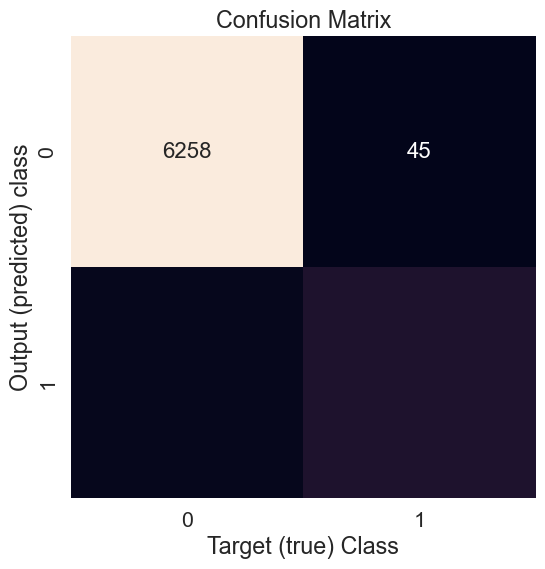

              precision    recall  f1-score   support

       licit       0.98      0.99      0.99      6303
     illicit       0.92      0.81      0.86       682

    accuracy                           0.97      6985
   macro avg       0.95      0.90      0.92      6985
weighted avg       0.97      0.97      0.97      6985



In [50]:
model.load_state_dict(torch.load(os.path.join(checkpoints_dir, 'tgnn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu())

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show()

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].cpu(),
                            target_names=['licit', 'illicit']))

In [ ]:
model = TGNN(input_dim, hidden_size, output_dim, 5).to(device)
model.load_state_dict(torch.load(os.path.join(checkpoints_dir, 'tgnn_best_model.pth.tar'))['state_dict'])

out = model(data_train.x, data_train.edge_index)

out_mod = np.array([-out.squeeze(1).detach().cpu().numpy(), out.squeeze(1).detach().cpu().numpy()]).T
